In [2]:
%load_ext autoreload
%autoreload 2
import math
from matplotlib import pyplot as plt
from train_box_model import initialize_model_and_state, OptimCfg
from jax.random import PRNGKey, split, normal
from box_model import make_box, rot_axis_to_quaternion, draw_box, overimpose_point_cloud, simulate, draw_box_no_bar, get_depth_pixel_from_plane, point_in_box_face, make_box_from_latents, DEF_DEPTH, get_depth_pixel_from_box, generative_model, score_many_point_clouds_from_many_latents
from jax import numpy as jnp
from jax import vmap, grad, value_and_grad
import jax

In [9]:
m, tx, opt_state, params, state = initialize_model_and_state(
        key=PRNGKey(1574),
        obs_length=100,
        optim_cfg=OptimCfg(),
        num_input_vars=3,
        load_idx=0,
        chkpt_folder="box_chkpts_high_cap_3/",
        deterministic = True,
    )

DeviceArray([0.87758255, 0.27679646, 0.27679646, 0.27679646], dtype=float32)

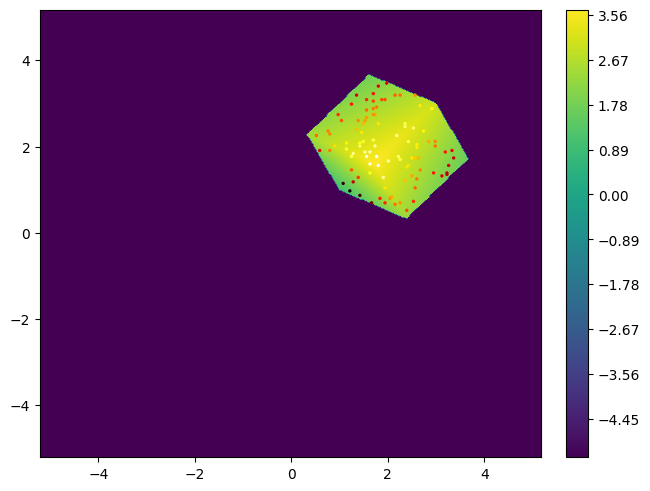

In [14]:
hx=1.0
hy=1.0
hz=1.0
q=rot_axis_to_quaternion(jnp.array([1,1.0,1.0])/3**0.5,jnp.array(1.0))
# q=rot_axis_to_quaternion(jnp.array([0,0,-1.0]),jnp.pi/2)
# hx,hy,hz = 1.0361311 ,  0.84753823,  0.21451688,
# q = jnp.array([0.24576879, -0.41609514, 0.0858047 ,  0.5095999])
# qn = jnp.linalg.norm(q)
# q /= qn
t=jnp.array([2.0,2.0,2.0])
latents = jnp.concatenate([jnp.stack([hx, hy, hz]), t, q])
pc, box = simulate(PRNGKey(0), latents, obs_noise_std=0.02, num_points=100)
def loss(l1,k):
    pc1, _ = simulate(PRNGKey(k), l1, obs_noise_std=0.02, num_points=100)
    return ((pc1-pc)**2).mean()
ax,fig = draw_box(box)
overimpose_point_cloud(fig, ax, pc)
# l1 = s[15]
# k = PRNGKeyey(568)
# for _ in range(1000):
#     k,sk = split(k)
#     lv, g = value_and_grad(loss)(jax.lax.stop_gradient(l1),sk)
#     l1 = l1 - 0.01 * g
#     print(lv)
q

In [13]:
num_samples = 25
my_sample = vmap(lambda k: m.apply(
    {"params": params, **state},
            pc[None],
            latents[None],
            rngs={"rsample_key": k,},)[1][0])
s = my_sample(split(PRNGKey(1),num_samples))
idx = ((s[:,:]-latents[None])**2).sum(-1).argsort()
s = s[idx]
s[:10,:3], s[:10,3:6], s[:10,6:]

(DeviceArray([[1.1168337 , 1.062279  , 0.80024004],
              [1.119766  , 0.8498132 , 1.0151463 ],
              [1.1026804 , 0.8192315 , 1.0084279 ],
              [1.3444517 , 0.8624027 , 0.8132303 ],
              [1.0572357 , 0.8258145 , 1.1035485 ],
              [1.0231597 , 0.96134496, 0.9056444 ],
              [0.7598922 , 1.1728551 , 1.0186391 ],
              [1.0219653 , 0.9803777 , 1.0386262 ],
              [1.0440953 , 1.0345066 , 0.9464123 ],
              [1.0877995 , 1.0347943 , 0.7589991 ]], dtype=float32),
 DeviceArray([[1.991951 , 1.9440422, 2.0153065],
              [1.9596963, 1.9731054, 2.0224438],
              [2.0075955, 1.9763584, 2.0194516],
              [1.9520111, 1.9373279, 2.0152955],
              [1.9826326, 1.9621482, 1.9608889],
              [1.9609561, 1.9784184, 1.962286 ],
              [1.9874215, 2.0014663, 1.9880934],
              [1.9602938, 1.9808536, 1.8993671],
              [1.9959373, 2.0036283, 1.9975753],
              [1.99803

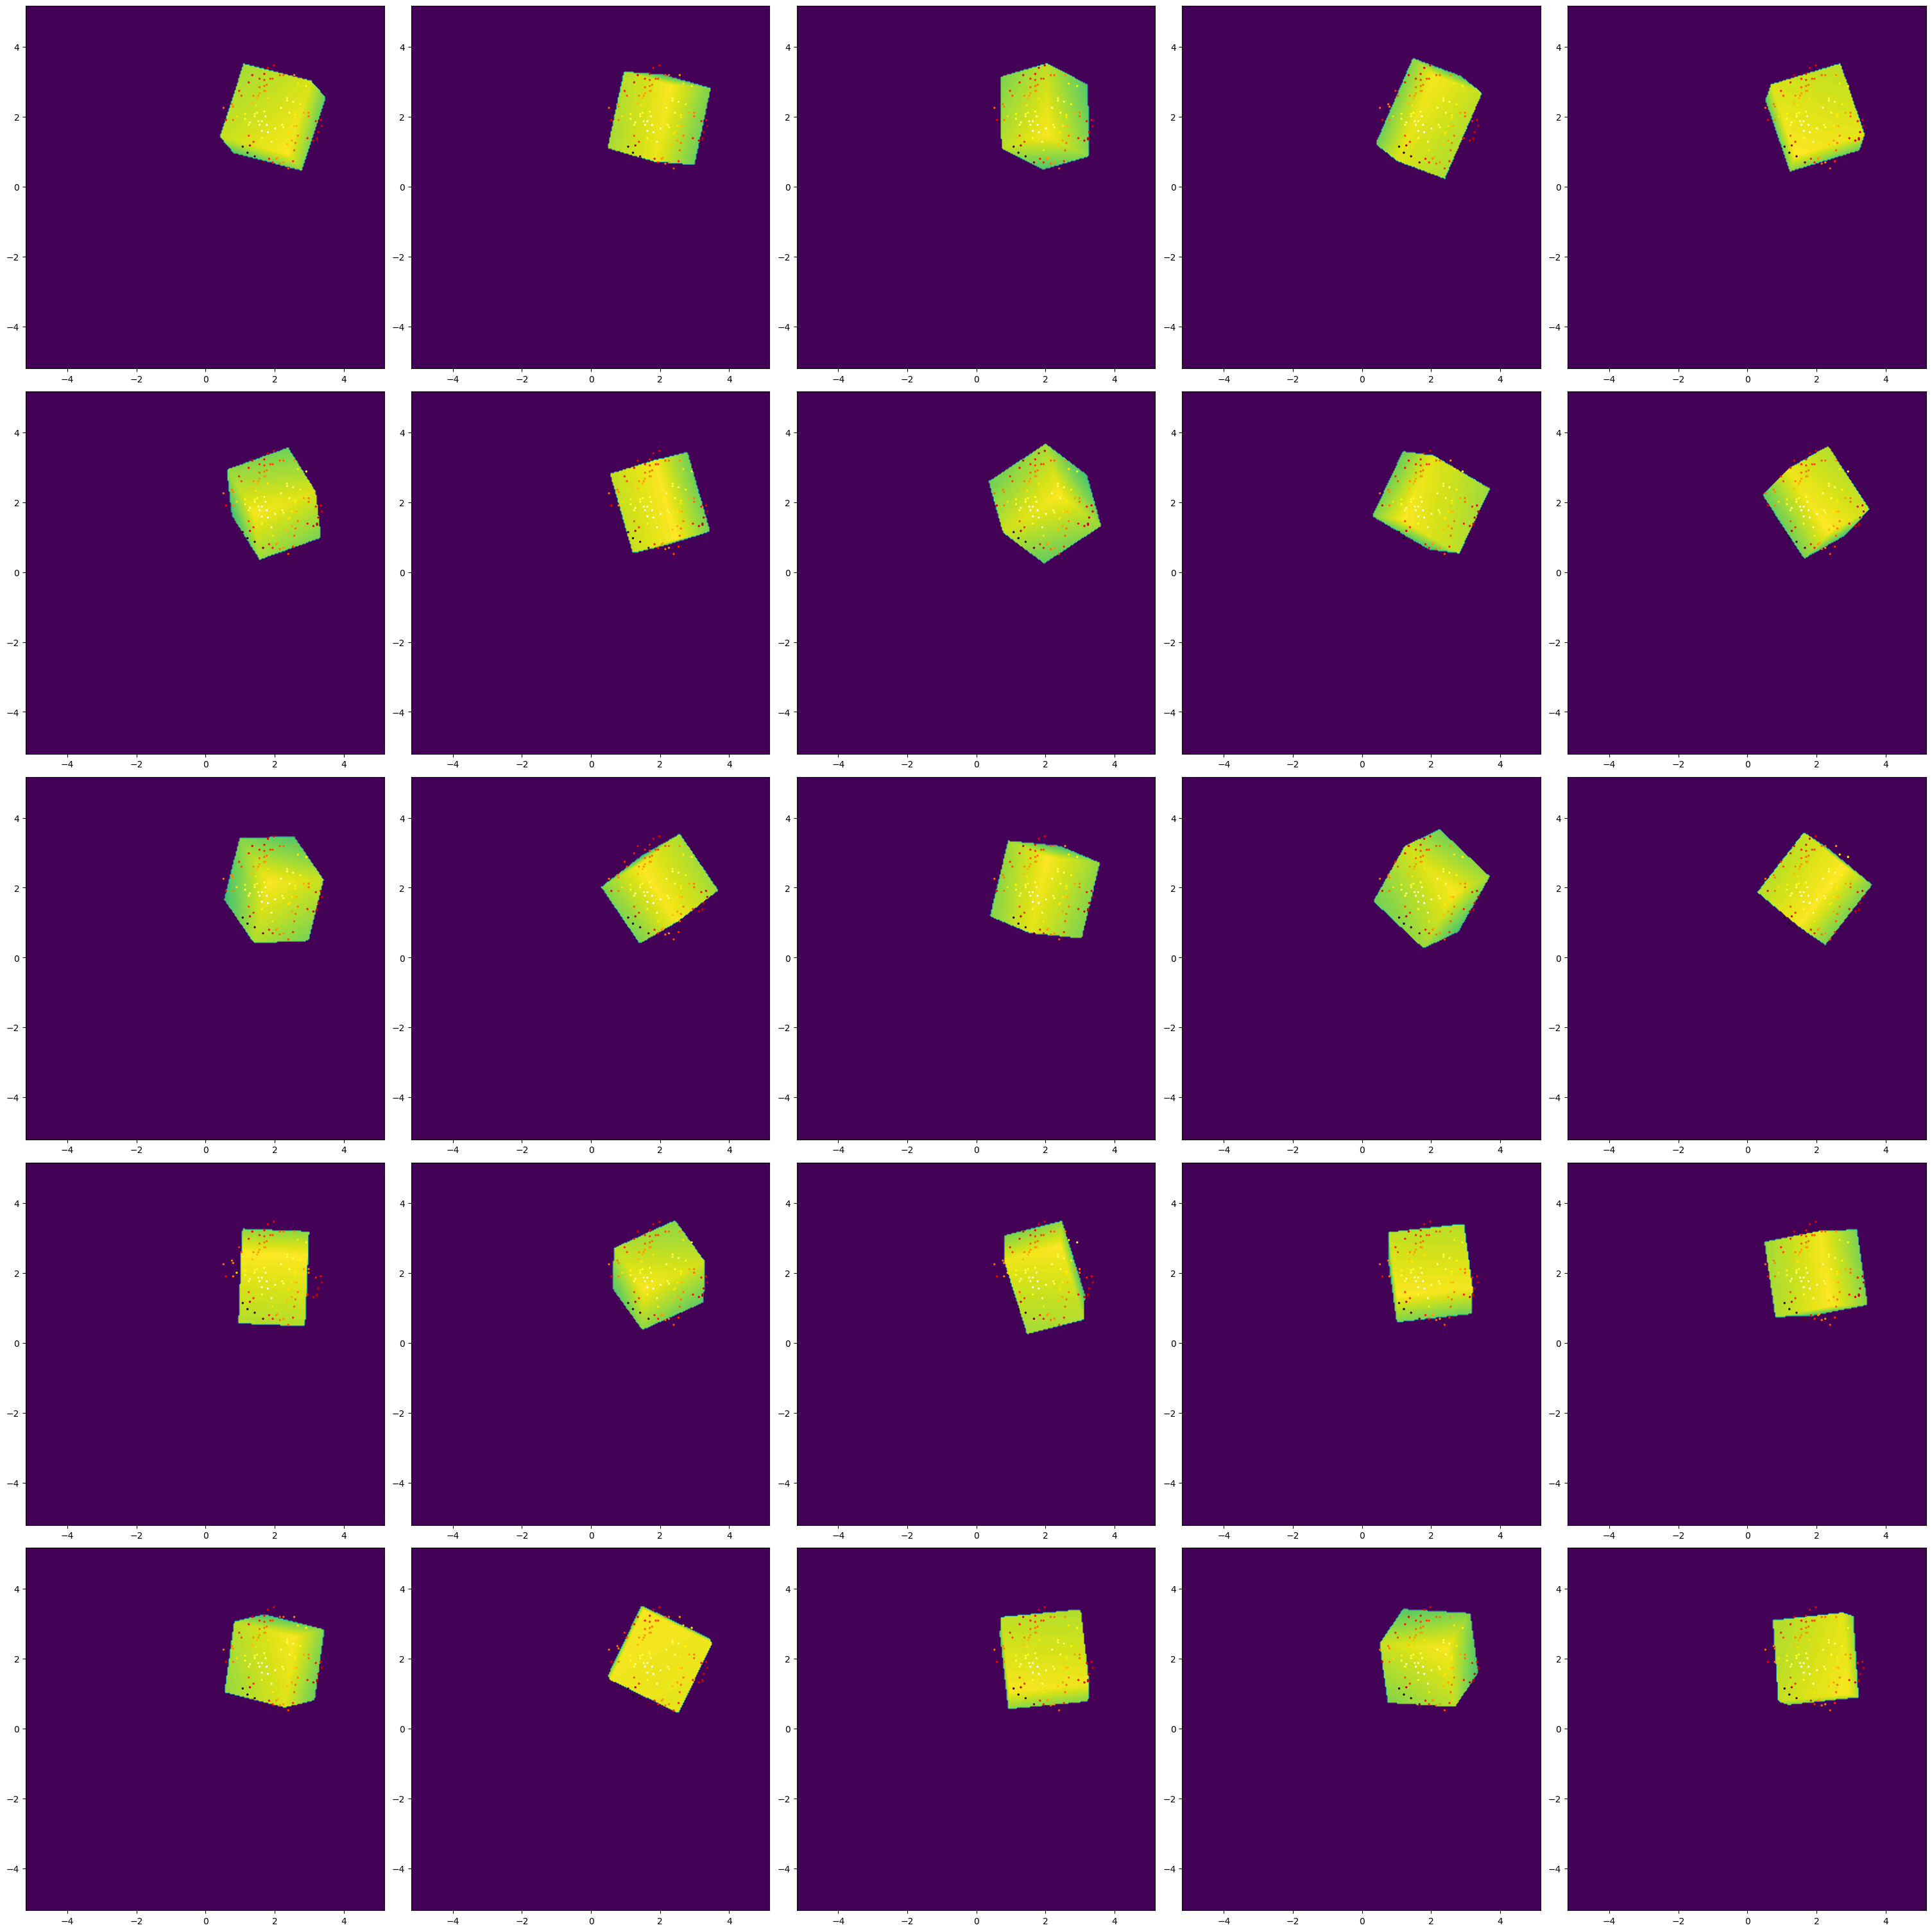

In [15]:
num_plots = num_samples
# num_plots = 25
num_cols = 5
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30), constrained_layout=True)

for i in range(num_plots):
    c = i % num_cols
    r = math.floor(i/num_cols)
    hx, hy, hz = s[i,:3]
    t = s[i,3:6]
    q = s[i,6:]
    qn = jnp.linalg.norm(q)
    q/=qn
    box = make_box(hx, hy, hz, t, q)
    draw_box_no_bar(box, axes[r,c])
    overimpose_point_cloud(fig, axes[r,c], pc)

In [11]:
# def score_point_box_face(point, face_plane, face_corners):
#     #TODO: should I just return the closest pixel? meanin
#     x,y,z = point
#     z_int = get_depth_pixel_from_plane(x,y, face_plane)
#     plane_inter = jnp.array([x,y,z_int])
#     z_int = jax.lax.cond(point_in_box_face(plane_inter, face_corners), lambda: z_int, lambda: DEF_DEPTH)
#     lpdf = jax.scipy.stats.norm.logpdf(z, loc=z_int)
#     return lpdf
    
def score_point_from_box(point, box):
    x,y,z = point
    z_box = get_depth_pixel_from_box(x,y,box)
    return jax.scipy.stats.norm.logpdf(z,loc=z_box)
    # all_scores = vmap(score_point_box_face, in_axes=(None,0,0))(point,box['faces_planes'], box['faces_corners'])
    # return all_scores.max()

def score_point_cloud_from_box(pc, box):
    all_scores = vmap(score_point_from_box, in_axes=(0,None))(pc, box)
    return all_scores.mean()

score_point_cloud_from_many_boxes = jax.jit(vmap(score_point_cloud_from_box, in_axes=(None, 0)))

In [67]:
def score_point_cloud_from_latents(pc,latents):
    box = make_box_from_latents(latents)
    return score_point_cloud_from_box(pc,box)

In [17]:
jnp.abs(vmap(score_point_cloud_from_latents,in_axes=(None,0))(pc,s))

DeviceArray([28.365793, 22.680695, 30.768398, ..., 31.838884, 31.838884,
             31.838884], dtype=float32)

(DeviceArray([-5.2219048e+00, -1.7762791e+01, -1.9052461e+00,
              -4.7013939e+01, -5.0374340e+01, -5.5039167e-01,
              -1.5356836e+00, -6.1283508e+02, -6.4794693e+01,
              -4.5698483e+01], dtype=float32),
 DeviceArray([ 47.018764 , 361.33627  ,   3.2185655,  43.770565 ,
              361.3351   ,   1.0891162,   1.6654634,  48.67835  ,
               90.00666  , 244.03989  ], dtype=float32),
 DeviceArray([ 0.6086132 ,  0.2238598 , -0.01190989, -0.08103913,
              -0.04414652,  0.09867408,  0.00466779, -0.18513015,
              -1.8787901 ,  0.03486453], dtype=float32),
 DeviceArray([1.0583968 , 0.27987894, 0.26634777, 1.08902   , 0.28925174,
              0.24571343, 0.11388591, 0.3441332 , 2.0485616 , 0.21780753],            dtype=float32))

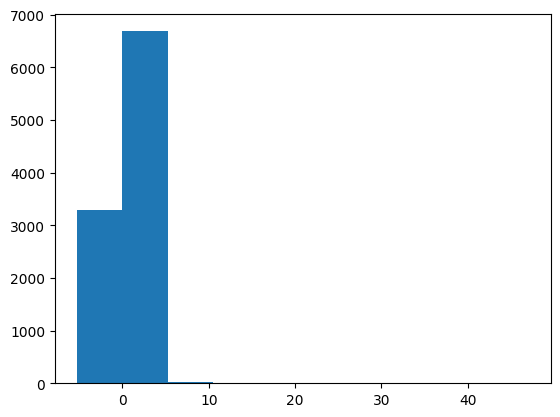

In [39]:
g = vmap(grad(score_point_cloud_from_latents, argnums=1),in_axes=(None,0))(pc,s)
# jax.tree_util.tree_map(lambda x: jnp.argwhere(jnp.isnan(x)), g)
plt.hist(g[jnp.abs(g).max(axis=1)>0][:,0])
g.min(axis=0),g.max(axis=0),g[jnp.abs(g).max(axis=1)>0].mean(axis=0), jnp.abs(g).mean(axis=0)

In [24]:
pc, latents, _ = jax.jit(vmap(generative_model, in_axes=(0,None,None)),static_argnums=(1, 2))(split(PRNGKey(0),2000),0.25,100)
pc.shape, latents.shape

((2000, 100, 3), (2000, 10))

In [68]:
log_prob, z = jax.jit(m.apply)(
    {"params": params, **state},
            pc,
            latents,
            rngs={"rsample_key": PRNGKey(0),},)
mask = jnp.ones((pc.shape[0],1))
mask = mask.at[75].set(0)
test = jax.jit(vmap(grad(score_point_cloud_from_latents, argnums=1)))(pc,z)
# def recon_loss(params,pc,latents):
#     _, z = m.apply(
#         {"params": params, **state},
#             pc[None],
#             latents[None],
#             rngs={"rsample_key": PRNGKey(0),}
#     )
jnp.argwhere(jnp.isnan(test))

DeviceArray([], dtype=int32)

In [65]:
latents[75], z[75], make_box_from_latents(z[75])
def norm(x,axis=None):
    is_zero = jnp.allclose(x, 0.)
    # temporarily swap x with ones if is_zero, then swap back
    x = jnp.where(is_zero, jnp.ones_like(x), x)
    n = jnp.linalg.norm(x, axis=axis)
    return jnp.where(is_zero, 0., n)
def quat_to_axis_angle(q):
  """Returns the axis-angle representation of a quaternion.

  Args:
    q: (4,) a quaternion

  Returns:
    The angle of axis-angle of this quaternion, in the range [-pi, pi].
  """
  # TODO: replace with more accurate safe function
  # avoid the singularity at 0:
  # epsilon = 1e-10
  # safety 1e-10 jitter added because both sqrt and arctan2 have bad gradients
  denom = norm(q[1:])
  angle = 2. * jnp.arctan2(
      jnp.sqrt(q[1] * q[1] + q[2] * q[2] + q[3] * q[3]), q[0])
  angle += jnp.where(angle > jnp.pi, x=-2 * jnp.pi, y=0)
  angle += jnp.where(angle < -jnp.pi, x=2 * jnp.pi, y=0)
  scale = jnp.where(denom == 0., 0., 1. / denom)
  return q[1:] * scale, angle
_, angle = quat_to_axis_angle(jnp.ones(4))
jnp.rad2deg(angle)

DeviceArray(120.00001, dtype=float32)

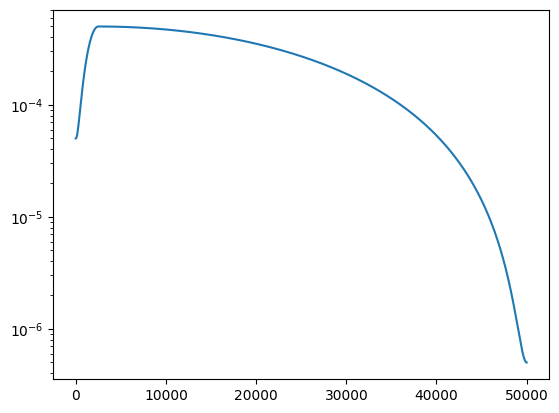

In [5]:
import optax
from jax import numpy as jnp
from jax import vmap
from matplotlib import pyplot as plt
schedule = optax.cosine_onecycle_schedule(50000, 5e-4,pct_start=0.05, div_factor=1e1, final_div_factor=1e2)
lrs = vmap(schedule)(jnp.arange(50000))
plt.plot(lrs)
plt.yscale('log')